# SmartSim: Online Visualization with MOM6

The Modular Ocean Model version 6 (MOM6) is a general circulation model used for operational and scientific simulations of the ocean. This particular simulation is a global simulation run at ~30km resolution and is run on 1,125 MPI ranks. Addiitonally, this simulation uses a neural network to infer eddy kinetic energy (replacing a prognostic partial differential equation) used in the parameterization of turbulence.

This notebook uses SmartSim to launch the experiment, initialize a python client, and use the client to extract the data from the database. A few functions are written to check to make sure all the ranks have posted a given field and to reconstruct a global array from each subdomain.

## Initializing the environment
The following contain the standard python import and the setting of the environment to ensure that all libraries needed to run the model will be available.

In [2]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean
import time
sys.path.append("/usr/local/lmod/lmod/init")
from env_modules_python import module

import smartredis
from driver_OM4_025 import mom6_clustered_driver


In [3]:
module('load','smartredis/gcc-9.3.0/0.3.0','cudatoolkit/11.2.0_3.39-7.0.3.0_2.1__gf93aa1c','cudnn/8.2.0')
ld_library_path = os.environ['LD_LIBRARY_PATH']
os.environ['LD_LIBRARY_PATH'] = f'{ld_library_path}:/usr/local/cuda-11.2/lib64'

## Configuring and launching the experiment
The driver function within ``driver.py`` is used to configure some basic parameters and return the SmartSim objects. We then start the experiment from this notebook.

In [3]:
experiment, mom_ensemble, orchestrator = mom6_clustered_driver(
    walltime="02:00:00",
    ensemble_size=1,
    nodes_per_member=25,
    tasks_per_node=45,
    mom6_exe_path="/lus/cls01029/shao/dev/gfdl/MOM6-examples/build/gnu/"+
                  "ice_ocean_SIS2/repro/MOM6",
    ensemble_node_features='[CL48|SK48|SK56]',
    mask_table="mask_table.315.32x45",
    domain_layout="32,45",
    eke_model_name="ncar_ml_eke.gpu.pt",
    eke_backend="GPU",
    orchestrator_port=6780,
    orchestrator_interface="ipogif0",
    orchestrator_nodes=3,
    orchestrator_node_features='P100',
    configure_only=True
)


18:26:30 horizon SmartSim[6218] INFO Working in previously created experiment


In [4]:
experiment.start(mom_ensemble, orchestrator, block=False)

18:26:33 horizon SmartSim[6218] INFO Orchestrator launched as a batch
18:26:33 horizon SmartSim[6218] INFO While queued, SmartSim will wait for Orchestrator to run
18:26:33 horizon SmartSim[6218] INFO CTRL+C interrupt to abort and cancel launch
18:26:59 horizon SmartSim[6218] INFO Database cluster created with 3 shards


## Helper functions
These following functions loop over all the keys associated with a field from within the database and retrieve an array that was posted to the database by each MPI rank. The general format of the key is `{ensemble_id}.{diagnostic_name}_{timestamp}_{mpi_rank}`. (Note: in the future the SmartRedis client itself will be able to perform the aggregation.)

In [5]:

def retrieve_all_ranks(client, ensemble_id, key_basename, nranks, dtype="float64"):
    retrieve_list_by_rank = []
    for rank in range(nranks):
        rank_id = f'{rank:06d}'        
        key = f'{ensemble_id}.{key_basename}_{rank_id}'
        retrieve_list_by_rank.append(client.get_tensor(key))
    return retrieve_list_by_rank


def reconstruct_domain(client, ensemble_id, key_basename, nranks, timestamp = None):
    """
    Reconstruct the domain of MOM6 by rank the metadata posted by MOM6
    """
    halo = 4
    meta_by_rank = retrieve_all_ranks(client, ensemble_id, f"meta" ,nranks)
    starti_by_rank = np.array([ int(meta[0]) for meta in meta_by_rank ])
    starti_by_rank = starti_by_rank - starti_by_rank.min()

    startj_by_rank = np.array([ int(meta[2]) for meta in meta_by_rank ])
    startj_by_rank = startj_by_rank - startj_by_rank.min()

    if timestamp:
        key = f'{key_basename}_{timestamp}.'
    else:
        key = key_basename
    
    array_by_rank = retrieve_all_ranks(client, ensemble_id, key, nranks)
    array_shape_by_rank = list(zip(*[ array.shape for array in array_by_rank ]))

    ni_by_rank = np.array(array_shape_by_rank[0])
    nj_by_rank = np.array(array_shape_by_rank[1])
    ni_global = (starti_by_rank + ni_by_rank).max()
    nj_global = (startj_by_rank + nj_by_rank).max()
    global_array = np.zeros((ni_global,nj_global))

    for rank in range(nranks):
        si = starti_by_rank[rank]
        ei = si + ni_by_rank[rank]
        sj = startj_by_rank[rank]
        ej = sj + nj_by_rank[rank]
        global_array[si:ei,sj:ej] = array_by_rank[rank]
    
    return global_array[halo:-halo,halo:-halo].transpose()


In [6]:
def all_ranks_posted( client, ensemble_id, key_basename, nranks, timestamp ):
  """
  Loop until all the ranks have posted the given diagnostic
  """
  found_all = False
  while not found_all:
    found_all = all( client.key_exists(f'{ensemble_id}.{key_basename}_{timestamp}._{rank:06d}') for rank in range(nranks) )
    if not found_all:
      print(f"Waiting for {key_basename}_{timestamp}...sleeping 5 seconds")
      time.sleep(5)


## Open auxiliary grid information
The MOM6 simulation does not use the full grid, since many of the subdomains are land-only. In order to properly visualize the data, we rely on the MOM6 input files themselves to provide the grid information. These are then merged into a single xarray dataset

In [7]:
# Load mask and lon/lat of grid from input files
mask = xr.open_dataset('../MOM6_config/INPUT/ocean_mask.nc').rename({'ny':'j','nx':'i'})
tmp  = xr.open_dataset('../MOM6_config/INPUT/seawifs-clim-1997-2010.1440x1080.v20180328.nc')[['lon','lat']]
ds = xr.merge([mask,tmp])


## Initialize the SmartSim Client

The following line initializes the Python client used in this notebook used to communicate with the database. The first argument gives the IP address (or hostname) and port of one of the database shards. The second argument is `True` to indicate that the database is spread over 3 (or more) nodes.

In [8]:
client = smartredis.Client(orchestrator.get_address()[0],True)

## Extract SmartRedis to an xarray dataset 
The auxiliary functions above are used to reconstruct the global arrays and add the eddy kinetic energy (the actual field used in the model for the Gent-McWilliams coefficient) to an xarray dataset. The array at timestep 1 is plotted in the first figure; then when timestep2 is available, the difference between the two is calculated and visualized.

Waiting for EKE_59886871200...sleeping 5 seconds
Waiting for EKE_59886871200...sleeping 5 seconds
Waiting for EKE_59886871200...sleeping 5 seconds


/home/users/shao/lus/shao/miniconda3/envs/smartsim-dev/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


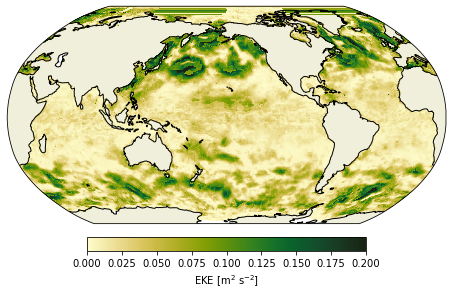

In [9]:
ensemble_id = 'MOM_0'
key_basename = 'EKE'
timestamp1 = '59886871200'
timestamp2 = '59886878400'
nranks = 32*45-315
all_ranks_posted( client, ensemble_id, key_basename, nranks, timestamp1 )
ds['EKE1'] = xr.DataArray(
  data=reconstruct_domain(client,ensemble_id,key_basename,nranks,timestamp1),
  dims = ['j','i'],  
)
ds = ds.where(ds.mask==1.)
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111,projection=ccrs.Robinson(central_longitude=200))
im = ax.pcolormesh( ds.lon, ds.lat, ds.EKE1,
                    vmin=0., vmax=0.2, transform=ccrs.PlateCarree(),
                    cmap = cmocean.cm.speed)
ax.add_feature(cfeature.LAND)
ax.coastlines()
fig.colorbar(im, ax=ax,label='EKE [m$^2$ s$^{-2}$]',orientation='horizontal', shrink=0.5, pad=0.05)

/home/users/shao/lus/shao/miniconda3/envs/smartsim-dev/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


Text(0.5, 1.0, '3-hour difference')

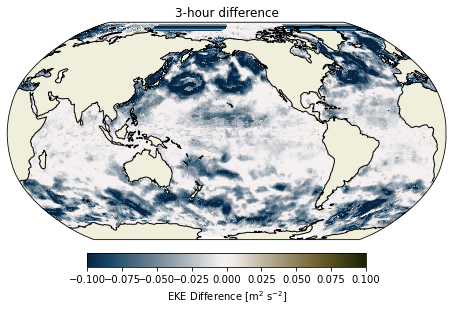

19:06:29 horizon SmartSim[6218] INFO MOM(2091590): Completed
20:26:46 horizon SmartSim[6218] INFO orchestrator(2091589): Completed


In [10]:
all_ranks_posted( client, ensemble_id, key_basename, nranks, timestamp2 )
ds['EKE2'] = xr.DataArray(
  data=reconstruct_domain(client,ensemble_id,key_basename,nranks,timestamp2),
  dims = ['j','i'],  
)
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111,projection=ccrs.Robinson(central_longitude=200))
im = ax.pcolormesh(ds.lon, ds.lat, ds.EKE2-ds.EKE1,
                   vmin=-0.1, vmax=0.1, transform=ccrs.PlateCarree(), cmap=cmocean.cm.diff)
ax.add_feature(cfeature.LAND)
ax.coastlines()
fig.colorbar(im, ax=ax,label='EKE Difference [m$^2$ s$^{-2}$]',orientation='horizontal', shrink=0.5, pad=0.05)
plt.title('3-hour difference')